# pySPaRTAN: a Python computational framework for linking cell-surface receptors to transcriptional regulators

## Introduction

Cell identity and function depend on complex signaling and transcriptional programs. Advances in single-cell technology have enabled the analysis of transcriptional states coupled with cell surface receptor expression. This tutorial will demonstrate the usage of our computational framework pySPaRTAN, a Python implementation of the SPaRTAN (Single-cell Proteomic and RNA-based Transcription factor Activity Network) framework. SPaRTAN models the flow of information from cell-surface receptors to transcription factors (TFs), then regulate target genes. pySPaRTAN utilizes CITE-seq data, which includes cell surface protein and gene expression, to infer TF activity.

<img src="pySPaRTAN_diagram_1.png" alt="Diagram" width="600" />

## Environment setup

Download the repository and follow the "Environment Setup" section in README.txt to install the Conda environment, JupyterLab, and Python packages listed in requirements_pyspartan.txt.

pySPaRTAN is a Python-based model. To enhance runtime performance, we converted certain computationally intensive Python functions into two Cython modules. Cython is platform-dependent, we need to build the cython objects on site.

Build two Cython objects. 

In [ ]:
! python  setup.py build_ext --inplace

If you encounter any issues while generating Cython objects, please refer to our pySPaRTAN GitHub page at https://github.com/osmanbeyoglulab/SPaRTAN/tree/main/pySPaRTAN for detailed instructions.

After successfully building the Cython objects, there are two .so files generated on a Mac/Linux machine or .pyd files on a Windows machine.

In [ ]:
! ls 

Use "ls" command on Mac computer; "dir" command on Windows computer

We import the python packages used in this tutorial

In [4]:
import scanpy as sc
from muon import prot as pt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from itertools import chain
from adjustText import adjust_text

from pySPaRTAN import pySPaRTAN

## Data pre-processing
### Data loading

We demonstrate the pipeline using the CITE-seq dataset of Peripheral Blood Mononuclear Cells (PBMC), which is freely available from 10X Genomics. 

We load the raw counts data saved in the .h5 file.

In [5]:
adata=sc.read_10x_h5("../data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
# making the variable name unique
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 5527 × 33570
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [6]:
set(adata.var["feature_types"])

{'Antibody Capture', 'Gene Expression'}

The ADT and RNA data are stored in the same adata object, differentiated by the feature_types variable. We will separate them into two distinct objects.

Extracting gene expression raw counts

In [7]:
RNA = adata[:, adata.var["feature_types"] == "Gene Expression"]

Extracting the ADT (protein) raw counts

In [8]:
ADT = adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()

# removing the isotype control for antibody
ADT=ADT[:,[x for x in ADT.var_names if "control" not in x]]

### Quality control

We calculate QC matrix and inspect some of the features:

* the number of genes expressed in the count matrix

* the total counts per cell

* the percentage of counts in mitochondrial genes

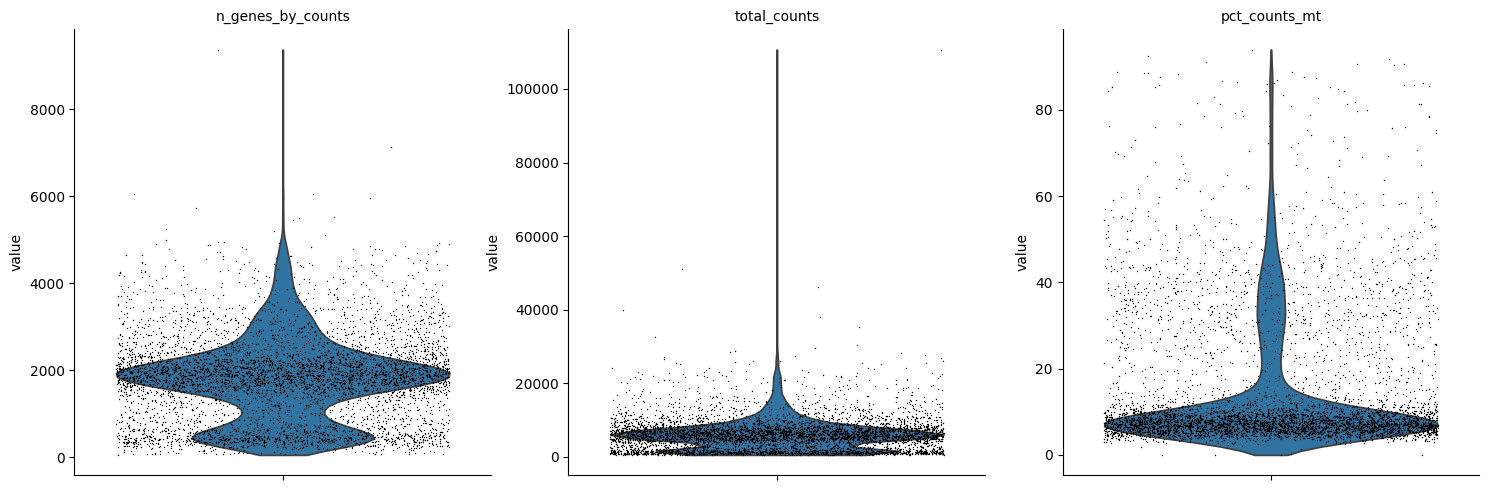

In [9]:
RNA.var['mt'] = RNA.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(RNA, qc_vars=['mt'], percent_top=None, log1p=False,inplace=True)

sc.pl.violin(
    RNA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Based on QC metric plots, we filter out cells with fewer than 1,000 or more than 5,000 unique gene sequences, as well as cells with more than 30% mitochondrial counts. Additionally, we exclude genes that are not present in at least 3% of cells. we also remove all mitoconondrial genes from the datset

In [10]:
sc.pp.filter_cells(RNA, min_genes=1000)
RNA=RNA[RNA.obs.query("n_genes_by_counts < 5000 and pct_counts_mt<30").index]

sc.pp.filter_genes(RNA, min_cells=0.03*RNA.n_obs)

# we also remove all mitoconondrial genes from the datset
RNA=RNA[:, RNA.var['mt']==False]

# Filter cells of ADT according to RNA
ADT = ADT[RNA.obs_names, :]

### Normalization

We scale the mRNA raw count data to a sum of 1e4 and normalize it with log1p transformation. 

In [11]:
sc.pp.normalize_total(RNA, target_sum=10000)
sc.pp.log1p(RNA)

For the protein, we normalize the raw counts using the center log ratio (CLR) transformation with the clr function from the Muon package.

In [12]:
pt.pp.clr(ADT)

## Cell type annotation

The pySPaRTAN model performs best when applied to data from different cell types separately. Next, we will prepare to annotate cell types.

Before further processing, we save the log-normalized mRNA data, which will be used as input for pySPaRTAN.

In [13]:
RNA.layers['log1p'] = RNA.X.copy()

### Feature selection
We subset features that only include highly variable genes which are highly expressed in some cells, and lowly expressed in others. Focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

We identify highly variable features and return top 5000 genes

In [14]:
sc.pp.highly_variable_genes(RNA, n_top_genes=5000)

### Dimensionality Reduction
Before reducing the dimensionality of the data, we apply a linear transformation that scales the data such that the mean expression across cells is 0 and the variance across cells is 1

In [15]:
sc.pp.scale(RNA)

We apply principal component analysis with default setting (return top 50 principal components)

In [16]:
sc.tl.pca(RNA)

To determine how many principal components we should choose to compute the neighborhood relations of the cells, we inspect the contribution of individual PCs to the total variance in the data

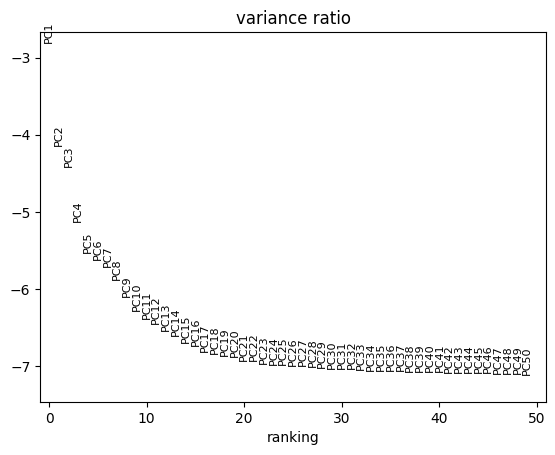

In [17]:
sc.pl.pca_variance_ratio(RNA, n_pcs=50, log=True)

From the elbow plot, we observe fist 20-30 principal components capture the majority of variance.

### Clustering

First construct a KNN graph based on the euclidean distance in PCA space

In [18]:
sc.pp.neighbors(RNA, n_neighbors=15, n_pcs=30)

Next cluster cells using  Leiden algorithm which is considered as an improved version of the Louvain algorithm

In [19]:
sc.tl.leiden(RNA, flavor="igraph", n_iterations=2)

Then We embed neighborhood graph into two-dimensional space and visualize it using UMAP

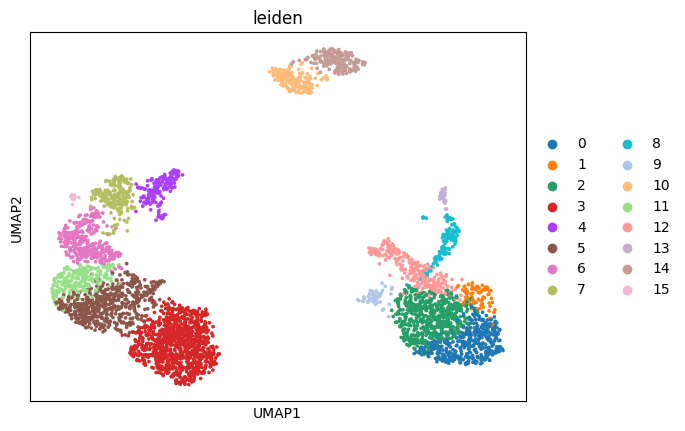

In [20]:
sc.tl.umap(RNA)
sc.pl.umap(RNA, color=["leiden"])

### Annotation

We annotated the cell types based on the marker genes and proteins listed below.

In [37]:
display(HTML('<header class="u-mb-16"><h4 class="c-article-satellite-title u-h1" id="table-2-title">Marker genes used to assign cell types to clusters</h4></header><div class="c-article-table-container"><div class="c-article-table-border c-table-scroll-wrapper"><div class="c-table-scroll-wrapper__content" data-component-scroll-wrapper=""><table class="data last-table"><thead class="c-article-table-head"><tr><th class="u-text-left "><p>Cell type</p></th><th class="u-text-left "><p>Marker genes</p></th><th class="u-text-left "><p>Marker proteins</p></th></tr></thead><tbody><tr><td class="u-text-left "><p>CD8+</p></td><td class="u-text-left "><p><i>CD8A</i>, <i>CD8B</i>, <i>FCER1G</i></p></td><td class="u-text-left "><p>CD8a, CD4</p></td></tr><tr><td class="u-text-left "><p>Naive CD4+ T</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>CCR7</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RA, CD4</p></td></tr><tr><td class="u-text-left "><p>Memory CD4+</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>S100A4</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RO, CD4</p></td></tr><tr><td class="u-text-left "><p>NK</p></td><td class="u-text-left "><p><i>GNLY</i>, <i>NKG7</i></p></td><td class="u-text-left "><p>CD56</p></td></tr><tr><td class="u-text-left "><p>DC</p></td><td class="u-text-left "><p><i>FCER1A</i>, <i>CST3</i></p></td><td class="u-text-left "> </td></tr><tr><td class="u-text-left "><p>CD14+ Mono</p></td><td class="u-text-left "><p><i>CD14</i>, <i>LYZ</i></p></td><td class="u-text-left "><p>CD14</p></td></tr><tr><td class="u-text-left "><p>FCGR3A+/CD16+ Mono</p></td><td class="u-text-left "><p><i>FCGR3A</i>, <i>MS4A7</i></p></td><td class="u-text-left "><p>CD16</p></td></tr><tr><td class="u-text-left "><p>B</p></td><td class="u-text-left "><p><i>MS4A1</i></p></td><td class="u-text-left "><p>CD20, CD19</p></td></tr></tbody></table></div></div></div><div class="u-text-right"></div>'))

Cell type,Marker genes,Marker proteins
CD8+,"CD8A, CD8B, FCER1G","CD8a, CD4"
Naive CD4+ T,"IL7R, CCR7, CD3E","CD45RA, CD4"
Memory CD4+,"IL7R, S100A4, CD3E","CD45RO, CD4"
NK,"GNLY, NKG7",CD56
DC,"FCER1A, CST3",
CD14+ Mono,"CD14, LYZ",CD14
FCGR3A+/CD16+ Mono,"FCGR3A, MS4A7",CD16
B,MS4A1,"CD20, CD19"


The process involved multiple iteration of subclustering and re-annotation, it's difficult to show the entire process. We load the saved cell_type annotation file. 

In [22]:
df_ct = pd.read_csv("../data/cell_types_PBMC.csv", index_col=0)

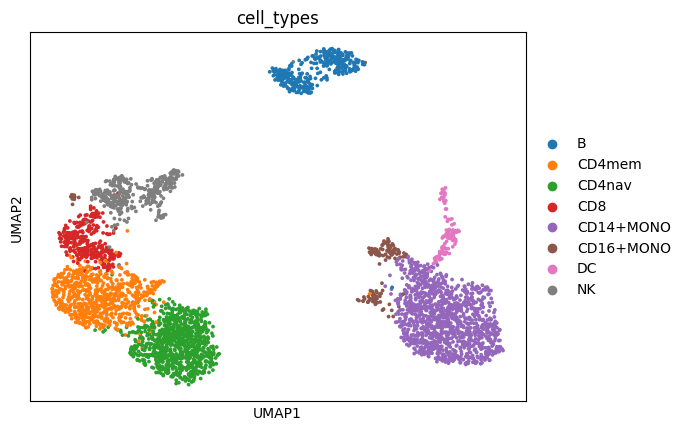

In [23]:
# Annotating cell type on UMAP
RNA=RNA[np.intersect1d(RNA.obs_names, df_ct.index)] 
RNA.obs["cell_types"] = df_ct.loc[RNA.obs_names]
sc.pl.umap(RNA, color=["cell_types"])

Checking number of cells for each cell type.

In [24]:
RNA.obs["cell_types"].value_counts()

cell_types
CD14+MONO    1203
CD4nav        910
CD4mem        716
NK            353
B             332
CD8           319
CD16+MONO     139
DC             99
Name: count, dtype: int64

## Reviewing pySPaRTAN model

pySPaRTAN is constructed as a bilinear regression model. The inputs are D: a gene-TF matrix, P: a cell x protein matrix, and Y: a gene x cell matrix. D is a prior dataset that can be downloaded online. P and Y are normalized protein and gene expression data derived from our processed CITE-seq data. The model learns the interaction matrix W between cell surface proteins and transcription factor activity that best predicts the target gene expression.

<img src="pySPaRTAN_diagram_2.png" alt="Diagram" width="600" />

<img src="equation_1.png" alt="Diagram" width="120" />

There are three inputs for the package: D, P Y

D: gene-tf matrix.

P: cell x ADT matrix. 

Y: gene x cell matrix, 


We convert this bilinear equation into a linear regression and apply approximations to expedite its solution. For method details, please refer to https://academic.oup.com/nar/article/49/17/9633/6368058 .

After training the model, we obtain the learned TF and protein interaction matrix W. From matrix W we can 
1. predict TF activities from the cell surface protein expression profile
   

2. protein activities from the cellular mRNA expression data and the TF-target gene matrix



<img src="pySPaRTAN_diagram_3.png" alt="Diagram" width="600" />

## Generating pySPaRTAN input data

Loading gene-TF matrix

In [25]:
# We load the curated gene-TF matrix for PBMC dataset
geneTF = pd.read_csv("../data/D_pbmc.csv", index_col=0)
geneTF.shape

(2643, 255)

Note: SPaRTAN model requires log normalized RNA expression as input. Current RNA.X has been scaled during cell type annotation, we need to load the normalized data back to RNA.X

In [26]:
RNA.X = RNA.layers['log1p']
# Aligning the genes in RNA with those in geneTF matrix
RNA = RNA[:, geneTF.index]

As we mentioned previously, tshe pySPaRTAN model performs best when applied separately to data from different cell types. We will extract RNA and ADT data for each cell type.

In [27]:
RNAs={}; ADTs={}
for celltype in set(df_ct["cell_types"]):
    index_type = df_ct.index[df_ct["cell_types"]==celltype]
    RNA_type = RNA[RNA.obs_names.isin(index_type)].to_df()
    ADT_type = ADT[ADT.obs_names.isin(index_type)].to_df()

    RNAs[celltype] = RNA_type
    ADTs[celltype] = ADT_type

RNAs.keys()

dict_keys(['CD4nav', 'NK', 'CD8', 'DC', 'CD16+MONO', 'CD4mem', 'B', 'CD14+MONO'])

## Training cell-type specific pySPaRTAN model
After preparing the input for pySPaRTAN, we are ready to run the model. We will use the CD8 T cell to demonstrate the procedure.

In [28]:
ct = "CD8"
D = geneTF.copy()
P = ADTs[ct].copy()
Y = RNAs[ct].copy()

In [29]:
D.shape, P.shape, Y.shape

((2643, 255), (319, 29), (319, 2643))

Before training the model, D, P and Y are all normalized with a unit norm within cells

In [30]:
D = pd.DataFrame(normalize(D.values, axis=0), index=D.index, columns=D.columns)
P = pd.DataFrame(normalize(P.values, axis=1), index=P.index, columns=P.columns)
Y = pd.DataFrame(normalize(Y.values, axis=1), index=Y.index, columns=Y.columns)

P and Y are normalized CD8 T cell protein and RNA expression where each row represent a cell and each column represent a protein or a gene.  Different cell type will have different dimension size of P and Y matrix. While gene-TF matrix has the fixed size for all cell types. 

Note: The P matrix is corresponding to the Pt in above diagram figure

We train the model using 80% of all cells in the dataset. The remaining 20% will be reserved for testing to evaluate the model’s performance.

In [31]:
P_train, P_test, Y_train, Y_test = train_test_split(
    P, Y, test_size=0.2, random_state=0)

In [33]:
lamdas = [0.001, 0.01, 0.1, 1, 5, 10]
rsL2s = [0.001, 0.01, 0.1, 0.5, 1]
spectrums = [0.7]

fold = 5

First we need to initiate the model with those parameters

In [35]:
model = pySPaRTAN(lamda_list = lamdas, rsL2_list = rsL2s, spectrum_list=spectrums, n_fold=fold)


Then train the model by passing the D, P, Y datasets

In [36]:
model.fit(D=D, P=P, Y=Y)

cross validating  spectrum=0.7, lambda=0.001, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.001, rsL2=0.01
cross validating  spectrum=0.7, lambda=0.001, rsL2=0.1
cross validating  spectrum=0.7, lambda=0.001, rsL2=0.5
cross validating  spectrum=0.7, lambda=0.001, rsL2=1
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.01
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.1
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.5
cross validating  spectrum=0.7, lambda=0.01, rsL2=1
cross validating  spectrum=0.7, lambda=0.1, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.1, rsL2=0.01
cross validating  spectrum=0.7, lambda=0.1, rsL2=0.1
cross validating  spectrum=0.7, lambda=0.1, rsL2=0.5
cross validating  spectrum=0.7, lambda=0.1, rsL2=1
cross validating  spectrum=0.7, lambda=1, rsL2=0.001
cross validating  spectrum=0.7, lambda=1, rsL2=0.01
cross validating  spectrum=0.7, lambda=1, rsL2=0.1
cross validating  spectrum=0.7,

After training the model on the training dataset, we evaluate its ability to predict gene expression based on protein expression using the testing dataset

In [38]:
score = model.get_pred_score(P_test, Y_test)
score

0.6988169964447761

This score is the correlation between predicted gene expression and observed gene expression, serving as the evaluation metric for prediction performance.

Now, we obtain the inferred TF activity for all CD8 T cells based on the its protein expression.

In [39]:
tf =model.get_projD(P)
tf

,CREB1,JUN,TEAD1,FOS,RXRA,PBX3,MYC,RARA,PPARG,PAX6,...,SMARCC1,KMT2B,FOXO4,SSRP1,SMAD5,ZNF274,UBTF,ZNF592,TGIF2,GATAD1
AACACACCAATCCTAG-1,0.221581,0.116749,-0.300838,0.420604,-0.218103,0.122931,0.569785,0.017732,0.302746,-0.018329,...,0.239970,-0.111198,-0.088936,0.432762,0.112675,0.231312,0.081378,-0.307120,0.151516,0.210916
AACAGGGAGCGAAACC-1,0.235006,0.125654,-0.302341,0.345550,-0.161842,0.089513,0.558269,0.011609,0.332151,-0.019063,...,0.251530,-0.147863,-0.048125,0.511758,0.057514,0.296642,0.102601,-0.259679,0.185528,0.240914
AACCAACTCGAGTACT-1,0.169015,0.164535,-0.296869,0.368001,-0.126398,0.168697,0.610518,0.038898,0.365439,-0.021185,...,0.252646,-0.108349,-0.204480,0.618730,0.084059,0.221342,0.087005,-0.339790,0.076915,0.176774
AACCATGCAATGCAAA-1,0.273832,0.124932,-0.338101,0.402688,-0.189067,0.089811,0.573770,-0.002789,0.360929,-0.031385,...,0.294399,-0.147030,0.032685,0.529729,0.068063,0.342330,0.119737,-0.271546,0.238405,0.290396
AACGGGAGTGAGATAT-1,0.257455,0.148260,-0.336375,0.418455,-0.165243,0.103775,0.589109,-0.022231,0.357996,-0.024953,...,0.271132,-0.128854,0.004378,0.539511,0.064214,0.313677,0.091705,-0.295510,0.219923,0.282253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTAATGCTC-1,0.276957,0.129643,-0.358245,0.355937,-0.162133,0.081972,0.569712,-0.005990,0.370643,-0.025032,...,0.297359,-0.144193,0.051766,0.561257,0.046030,0.362971,0.107072,-0.262173,0.254324,0.305878
TTGTTGTGTACCTTCC-1,0.199842,0.149070,-0.288516,0.472791,-0.230031,0.147158,0.625178,0.016048,0.310887,-0.020548,...,0.227983,-0.139622,-0.168184,0.488882,0.126671,0.221857,0.094452,-0.325231,0.130022,0.199857
TTGTTTGTCGACCCAG-1,0.172328,0.150784,-0.285579,0.408153,-0.183833,0.161336,0.573629,0.018293,0.327117,-0.030636,...,0.254544,-0.155743,-0.145554,0.586591,0.117111,0.256455,0.098228,-0.295889,0.127106,0.224260
TTTAGTCTCGGTGCAC-1,0.215783,0.123052,-0.267282,0.453502,-0.219097,0.138278,0.623288,0.035727,0.344296,-0.016640,...,0.268812,-0.143329,-0.169325,0.494992,0.103566,0.210548,0.143309,-0.333869,0.109553,0.171340


## Analyzing results

Here we explore the associations between inferred TF activity and surface protein expression at a single-cell level.

We first compute Pearson correlation coefficients between inferred TF activity and surface protein expression for each TF-protein pair within the cell-type

In [40]:
tf_protein = model.get_tf_protein_cor()
tf_protein

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD11b_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB,CD16_TotalSeqB,CD19_TotalSeqB,CD20_TotalSeqB,CD25_TotalSeqB,...,CD86_TotalSeqB,CD127_TotalSeqB,CD137_TotalSeqB,CD197_TotalSeqB,CD274_TotalSeqB,CD278_TotalSeqB,CD335_TotalSeqB,PD-1_TotalSeqB,HLA-DR_TotalSeqB,TIGIT_TotalSeqB
CREB1,-0.424472,-0.642362,0.633641,-0.431235,-0.184781,-0.308417,-0.243081,-0.177414,0.298939,-0.045521,...,-0.020474,0.086146,-0.020800,-0.142421,-0.188374,-0.316033,-0.295488,-0.060510,-0.061636,0.230757
JUN,0.387326,0.735389,-0.776577,0.224484,0.188679,0.358378,0.263951,0.201211,-0.039022,0.128938,...,-0.005178,0.428158,0.016111,0.295634,0.219404,0.290449,0.307566,0.098277,-0.116990,-0.166163
TEAD1,-0.001045,0.076261,0.195310,0.234698,0.002156,-0.090080,0.123510,0.046052,-0.351203,-0.118611,...,0.019478,-0.585536,-0.005675,-0.154333,-0.033624,0.157883,0.085403,-0.214563,0.169261,0.070563
FOS,-0.152832,0.127538,0.180320,0.012936,-0.080555,-0.127972,0.190136,0.044383,-0.259809,-0.226445,...,-0.013333,-0.490957,0.046968,-0.053063,-0.002493,0.209276,0.114402,0.062731,-0.026370,0.515909
RXRA,0.319177,-0.148347,-0.303162,-0.024560,0.138138,0.207019,-0.070217,-0.025964,0.255761,0.288063,...,0.046589,0.532124,0.067275,0.138126,-0.038763,-0.253948,-0.007879,-0.337740,0.073693,-0.307098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF274,-0.245809,-0.124299,0.029928,-0.404807,-0.088209,-0.095430,-0.203609,-0.080019,0.387534,0.064059,...,-0.043022,0.619189,-0.040736,0.023610,-0.049612,-0.174626,-0.216570,0.215133,-0.179665,-0.074314
UBTF,-0.213270,0.670465,0.029494,-0.012600,-0.062378,-0.135669,-0.060691,0.080866,-0.155764,-0.152287,...,0.024349,-0.019910,-0.008592,-0.028141,0.011687,0.735313,-0.231463,0.491507,-0.013502,-0.293608
ZNF592,-0.363745,0.474076,-0.351921,-0.254695,-0.055625,-0.048596,-0.144645,0.013753,0.214509,0.039255,...,-0.059841,0.640892,-0.057983,-0.014310,0.031835,0.016962,-0.132546,0.443296,-0.140935,-0.298423
TGIF2,-0.419258,0.043880,-0.017498,-0.335759,-0.118387,-0.135458,-0.192550,-0.079082,0.326119,0.026176,...,-0.047231,0.577603,-0.017287,0.037755,-0.047246,-0.112098,-0.218047,0.371447,-0.205132,-0.090310


Trim the end of protein names

In [41]:
tf_protein.columns = tf_protein.columns.str[:-10]
tf_protein.columns

Index(['CD3', 'CD4', 'CD8a', 'CD11b', 'CD14', 'CD15', 'CD16', 'CD19', 'CD20',
       'CD25', 'CD27', 'CD28', 'CD34', 'CD45RA', 'CD45RO', 'CD56', 'CD62L',
       'CD69', 'CD80', 'CD86', 'CD127', 'CD137', 'CD197', 'CD274', 'CD278',
       'CD335', 'PD-1', 'HLA-DR', 'TIGIT'],
      dtype='object')

We filter out the TF and protein with lower absolute correlation values 

In [42]:
proteins_to_plot = tf_protein.columns[abs(tf_protein).max(axis=0) > 0.7]
tfs_to_plot = tf_protein.index[abs(tf_protein).max(axis=1) > 0.85]
tf_protein_plot = tf_protein.loc[tfs_to_plot, proteins_to_plot]

Then we plot heatmap of the selected protein-TF correlation

Text(0.5, 1.05, 'CD8 T cell protein-TF correlation')

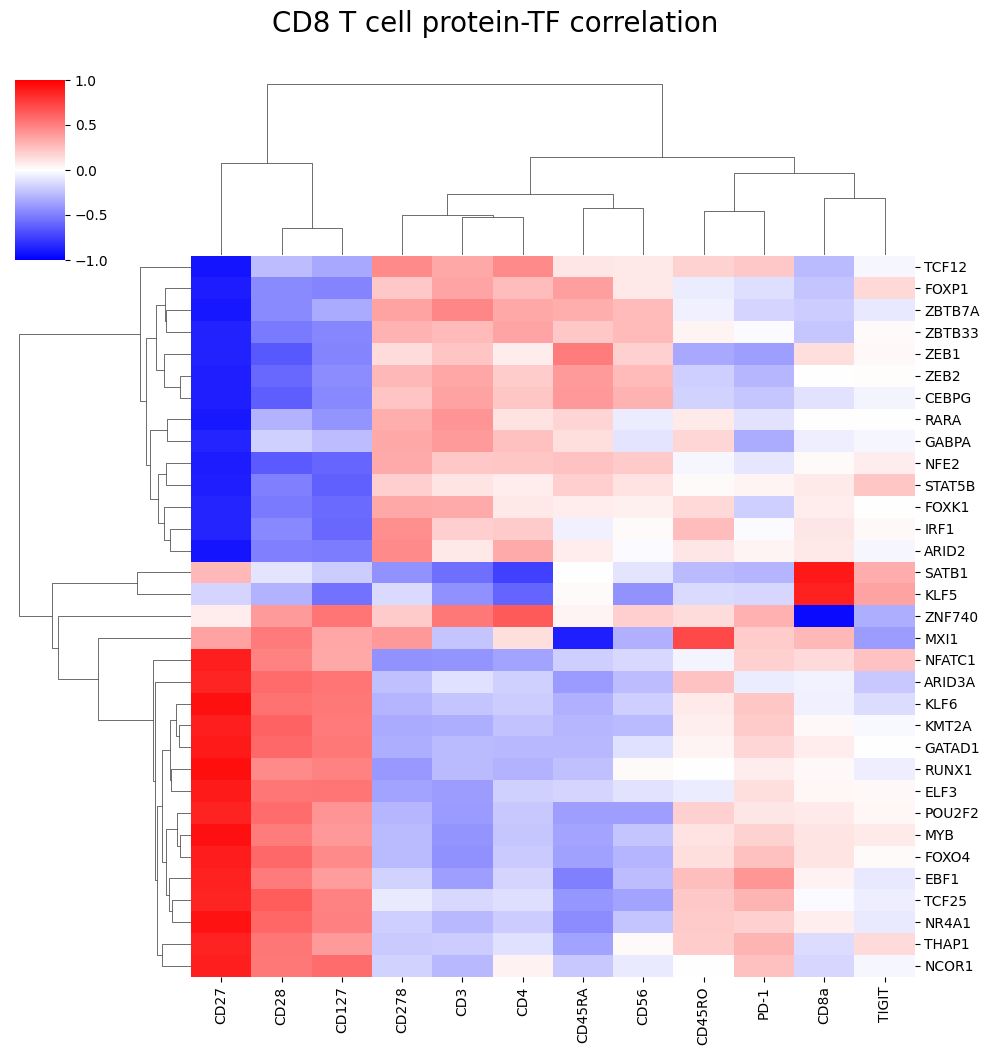

In [43]:
sns.clustermap(
    tf_protein_plot,
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle(ct + " T cell protein-TF correlation", y=1.05,fontsize=20)

Finally, we plot the TF correlation with specific protein, highlight the TFs with highest and lowest correlations.

Defining the plot function

In [44]:
def line_plot(pcc,prot, N, ax):
    
    pcc_prot = pcc.loc[:, prot].sort_values()

    labels = pcc_prot.index

    x= range(1,len(pcc_prot)+1)
    y=pcc_prot

    ax.scatter(x, y, s=8)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    texts = [ax.text(x[i], y[i], '%s' %labels[i], ha='center', va='center', fontsize=10) for i in range_c]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r'), ax=ax, min_arrow_len=0, time_lim=0.1)

    ax.set_xlabel("TF ranking", fontsize=15)
    ax.set_ylabel(f"Corr between {prot} exp and TF activity", fontsize=15)
    ax.set_title(prot)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    TF_labels = [labels[i] for i in range_c]
    return(TF_labels)


Plotting lineplot

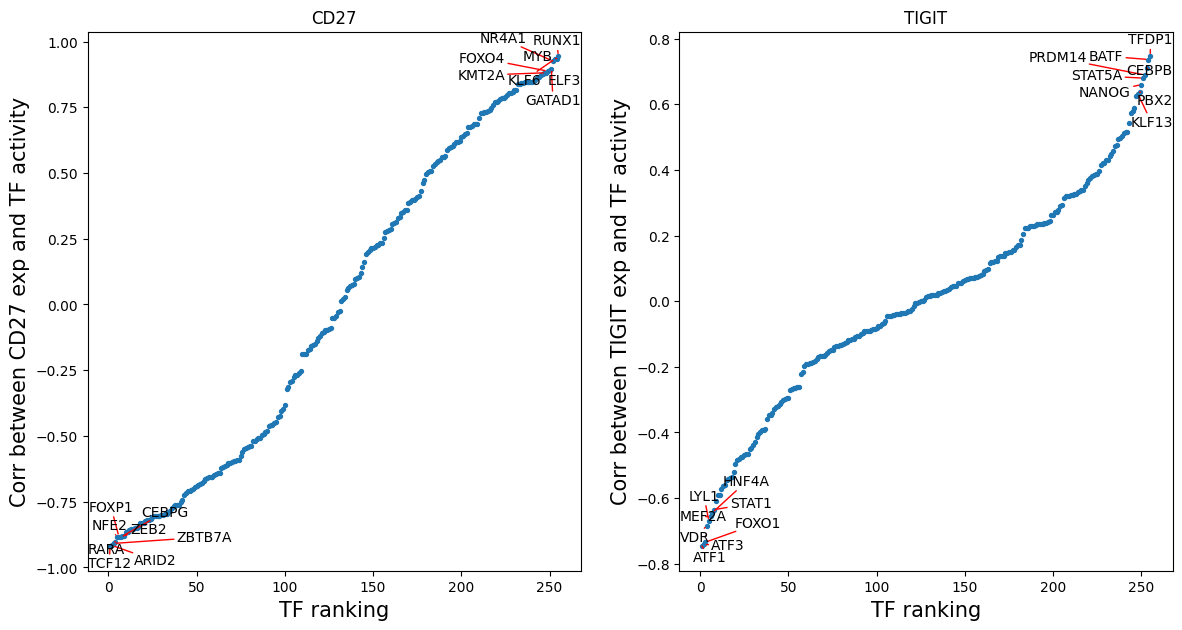

In [45]:
plt.rcParams['figure.figsize'] = [14, 7]
fig, ax = plt.subplots(1,2)
prot = "CD27"
line_plot(tf_protein, prot, 8, ax[0])
prot = "TIGIT"
line_plot(tf_protein, prot, 8, ax[1])

fig.show()


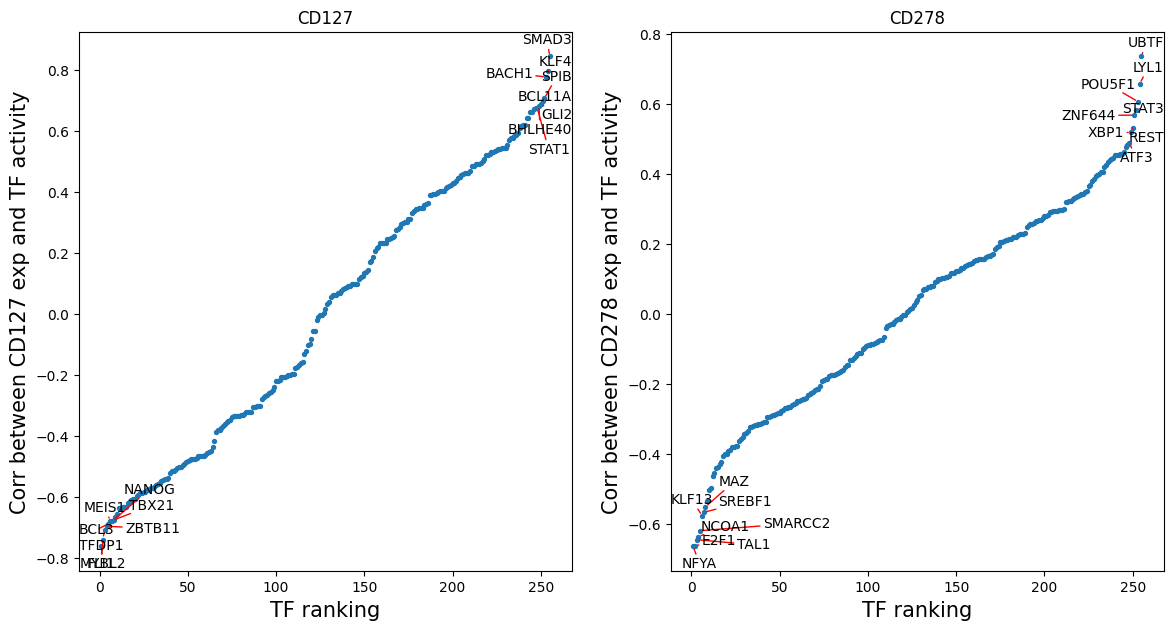

In [46]:
plt.rcParams['figure.figsize'] = [14, 7]
fig, ax = plt.subplots(1,2)
prot = "CD127"
line_plot(tf_protein, prot, 8, ax[0])
prot = "CD278"
line_plot(tf_protein, prot, 8, ax[1])

fig.show()
